# XGBoost miRNA
Runs XGBoostClassifer on miRNA data.  

Three datasets are analyzed using the XGBoost classifier:
* Sham and infeceted mice from all weeks; i.e., 8 week and 16 week datasets are merged.
* Sham and infected mice at 8 weeks.
* Sham and infected mice at 16 weeks.

In each dataset, there is a flag (named ‘infected’) that marks whether the mice came from the infected group or the sham group.  
XGBoost's variable importance and SHAP values are then used to determine which miRNA variable was most important in each cohort dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, roc_auc_score, roc_curve, mean_absolute_error
from IPython.display import display
import random
import shap

In [4]:
! python --version

Python 3.11.4


In [5]:
print('xgboost version', xgb.__version__)
print('sklearn version', sklearn.__version__)
print('shap version', shap.__version__)

xgboost version 1.7.6
sklearn version 1.3.0
shap version 0.42.1


### helper functions

In [6]:
def make_study_df(miRNA_df, infected_str='tf_', cohort_str=None):
    df = miRNA_df.copy()

    # subset to cohort
    if cohort_str:
        df = df[df.cohort.str.endswith(cohort_str)]
    
    # add column to identify infected mice
    df['infected'] = np.where(df.cohort.str.startswith(infected_str), 1, 0)

    # drop cohort, number, and name data
    df = df.iloc[:, 4:] 
    
    # shuffle data
    df = df.sample(frac=1, random_state=1989)

    # shuffle columns
    cols = list(df.columns)
    random.shuffle(cols)
    df = df[cols]
        
    return df

In [7]:
def plot_xgb_feature_importance(
    model, 
    title='',
    num_features=5,
    size_width=8,
    size_height=4,
    font_size=12,
    y_label='',
    save_fig=True,
    dpi=300
):
    xgb.plot_importance(model, max_num_features=num_features)
    ax = plt.gca()
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=font_size)
    plt.ylabel(y_label)
    plt.title(title)
    plt.gcf().set_size_inches(size_width, size_height)

    if save_fig:
        if len(title) > 0:
            fname = f'../figures/{title.replace(" ", "_")}.png'
        else:
            fname = f'../figures/xgboost_feature_importance_{random.randint(1, 1_000_000)}.png'
        plt.savefig(fname, dpi=dpi, bbox_inches='tight')
        
    plt.show()

In [8]:
# see https://stackoverflow.com/questions/39803385/what-does-a-4-element-tuple-argument-for-bbox-to-anchor-mean-in-matplotlib
# for explanation of bbox_to_anchor values
def plot_shap_feature_importance(
    shap_values, 
    title='',
    num_features=6,
    size_width=8,
    size_height=4,
    font_size=12,
    y_label='',
    cohorts=2,
    legend_loc='best',
    bbox_values=(0, 0, 1, 1),
    save_fig=True,
    dpi=300
):
    if cohorts > 0:
        shap.plots.bar(shap_values.cohorts(cohorts).abs.mean(0), max_display=num_features, show=False)
    else:
        shap.plots.bar(shap_values, max_display=num_features, show=False)
    
    ax = plt.gca()
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=font_size)
    plt.ylabel(y_label)
    plt.title(title)
    if cohorts > 0: 
        plt.legend(loc=legend_loc, bbox_to_anchor=bbox_values)
    plt.gcf().set_size_inches(size_width, size_height)

    if save_fig:
        if len(title) > 0:
            fname = f'../figures/{title.replace(" ", "_")}.png'
        else:
            fname = f'../figures/shap_values_feature_importance_{random.randint(1, 1_000_000)}.png'
        plt.savefig(fname, dpi=dpi, bbox_inches='tight')
        
    plt.show()

In [9]:
def plot_shap_summary(
    shap_values,
    X_data,
    title='',
    num_features=5,
    size_width=6,
    size_height=3,
    font_size=12,
    y_label='',
    save_fig=True,
    dpi=300
):
    shap.summary_plot(shap_values, X_data, max_display=num_features, show=False)
    ax = plt.gca()
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=font_size)
    plt.ylabel(y_label)
    plt.title(title)
    plt.gcf().set_size_inches(size_width, size_height)

    if save_fig:
        if len(title) > 0:
            fname = f'../figures/{title.replace(" ", "_")}.png'
        else:
            fname = f'../figures/shap_values_summary_{random.randint(1, 1_000_000)}.png'
        plt.savefig(fname, dpi=dpi, bbox_inches='tight')
        
    plt.show()

In [10]:
def plot_shap_heatmap(
    shap_values,
    title='',
    num_features=5,
    size_width=8,
    size_height=5,
    font_size=12,
    save_fig=True,
    dpi=300
):
    shap.plots.heatmap(shap_values, max_display=num_features, show=False)
    ax = plt.gca()
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=font_size)
    plt.title(title)
    plt.gcf().set_size_inches(size_width, size_height)

    if save_fig:
        if len(title) > 0:
            fname = f'../figures/{title.replace(" ", "_")}.png'
        else:
            fname = f'../figures/shap_values_summary_{random.randint(1, 1_000_000)}.png'
        plt.savefig(fname, dpi=dpi, bbox_inches='tight')
        
    plt.show()

In [11]:
def plot_shap_dependence(
    shap_values,
    X_data,
    title='',
    num_features=5,
    size_width=8,
    size_height=5,
    font_size=12,
    save_fig=True,
    dpi=300
):
    shap.dependence_plot("rank(0)", shap_values.values, X_data, display_features=X_data, show=False)
    ax = plt.gca()
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=font_size)
    plt.title(title)
    plt.gcf().set_size_inches(size_width, size_height)

    if save_fig:
        if len(title) > 0:
            fname = f'../figures/{title.replace(" ", "_")}.png'
        else:
            fname = f'../figures/shap_dependence_plot_{random.randint(1, 1_000_000)}.png'
        plt.savefig(fname, dpi=dpi, bbox_inches='tight')
        
    plt.show()

## load miRNA data

In [12]:
miRNA_df = pd.read_excel('../data/transposed_Tf_miRNA.xlsx')

## create dataframes and X, y datasets

In [13]:
df_all_weeks = make_study_df(miRNA_df)
df_8_weeks = make_study_df(miRNA_df, cohort_str='8_weeks')
df_16_weeks = make_study_df(miRNA_df, cohort_str='16_weeks')

In [14]:
X_all_weeks, y_all_weeks = df_all_weeks.drop('infected', axis=1), df_all_weeks['infected']
X_8_weeks, y_8_weeks = df_8_weeks.drop('infected', axis=1), df_8_weeks['infected']
X_16_weeks, y_16_weeks = df_16_weeks.drop('infected', axis=1), df_16_weeks['infected']

### compute XGBoost models

In [15]:
params = {
    "random_state": 42,
    "objective":"binary:logistic",
    "colsample_bytree": 0.3, 
    "learning_rate": 0.1,
    #"nfold": 5,
    #"num_boost_round": 100, 
    #"early_stopping_rounds": 10, 
    #"metrics": "accuracy"
}   

In [16]:
model_all_weeks = xgb.XGBClassifier(**params).fit(X_all_weeks, y_all_weeks)
model_8_weeks = xgb.XGBClassifier(**params).fit(X_8_weeks, y_8_weeks)
model_16_weeks = xgb.XGBClassifier(**params).fit(X_16_weeks, y_16_weeks)

### compute SHAP values (used for explainablity)

In [17]:
# need to change int and bool to classes int_ and bool_ to handle error 'numpy' has no attribute 'int'/'bool'/etc.
np.bool = np.bool_
np.int = np.int_
np.float = np.float_

In [18]:
explainer_all_weeks = shap.TreeExplainer(model_all_weeks, X_all_weeks, feature_names=X_all_weeks.columns.tolist())
shap_values_all_weeks = explainer_all_weeks(X_all_weeks)

explainer_8_weeks = shap.TreeExplainer(model_8_weeks, X_8_weeks, feature_names=X_8_weeks.columns.tolist())
shap_values_8_weeks = explainer_8_weeks(X_8_weeks)

explainer_16_weeks = shap.TreeExplainer(model_16_weeks, X_16_weeks, feature_names=X_16_weeks.columns.tolist())
shap_values_16_weeks = explainer_16_weeks(X_16_weeks)

---

## Bar plots of feature importance
The XGBoost feature importance differs from the SHAP feature importance. They are measuring differently. See this [article](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27) for details.

## bar plots for all weeks

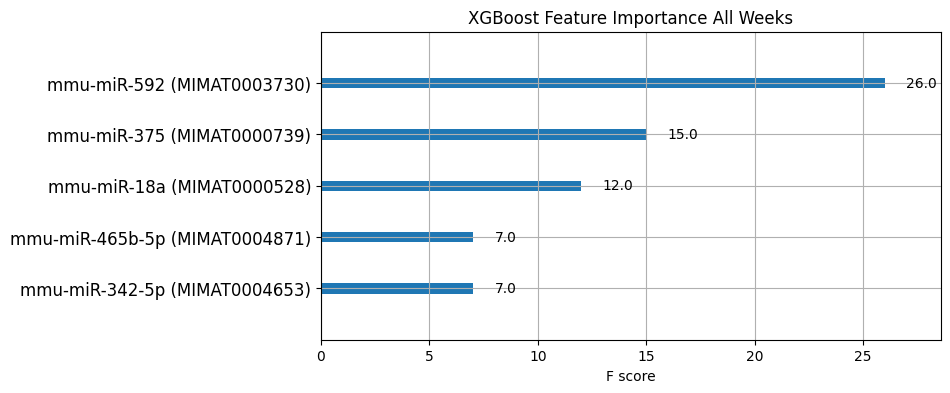

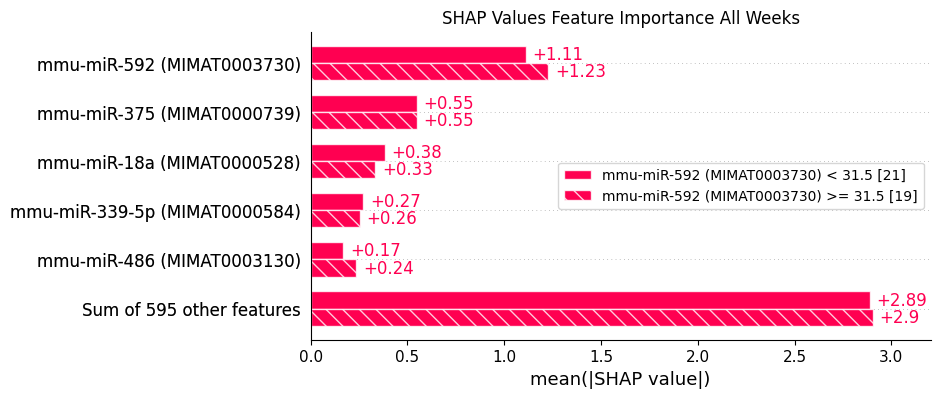

In [19]:
plot_xgb_feature_importance(model_all_weeks, 'XGBoost Feature Importance All Weeks')
plot_shap_feature_importance(shap_values_all_weeks, 'SHAP Values Feature Importance All Weeks')

## bar plots for 8 weeks

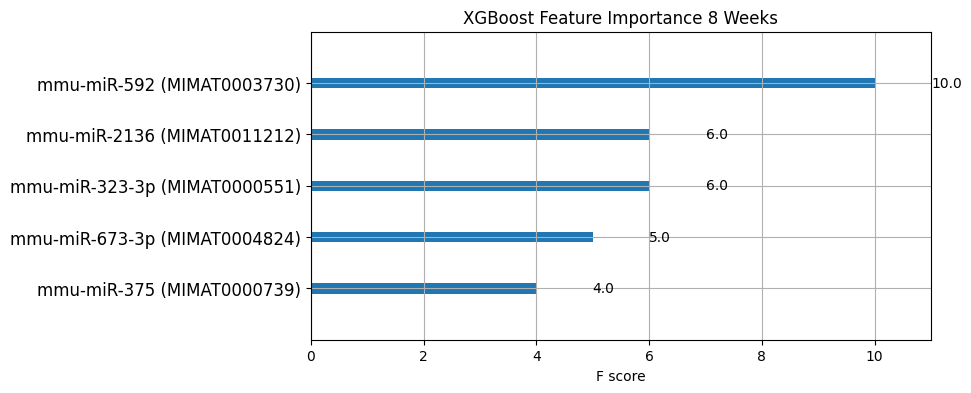

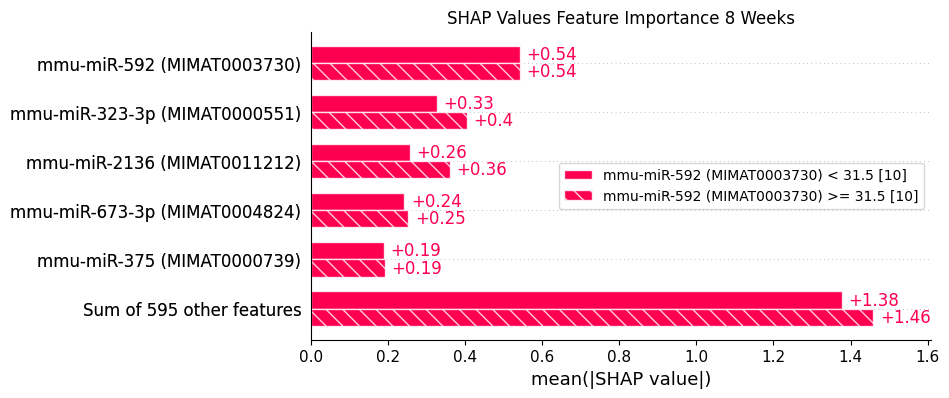

In [20]:
plot_xgb_feature_importance(model_8_weeks, 'XGBoost Feature Importance 8 Weeks')
plot_shap_feature_importance(shap_values_8_weeks, 'SHAP Values Feature Importance 8 Weeks')

## bar plots for 16 weeks

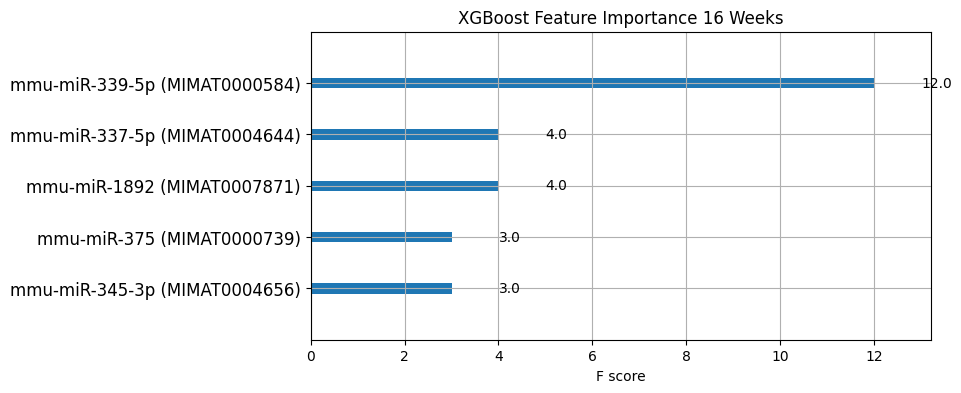

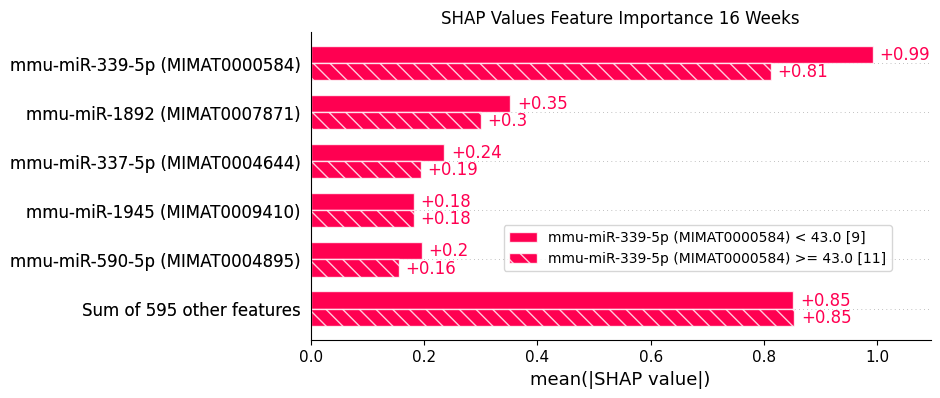

In [21]:
plot_xgb_feature_importance(model_16_weeks, 'XGBoost Feature Importance 16 Weeks')
plot_shap_feature_importance(
    shap_values_16_weeks, 
    'SHAP Values Feature Importance 16 Weeks', 
    legend_loc='lower left',
    bbox_values=(0.3, 0.2)
)

## SHAP summary plots

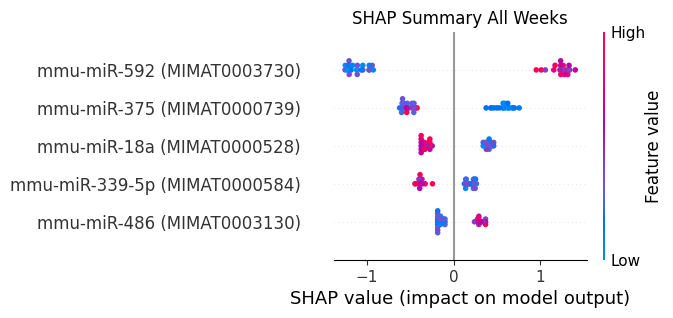

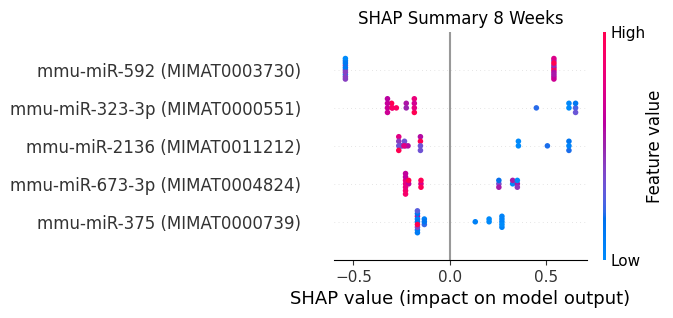

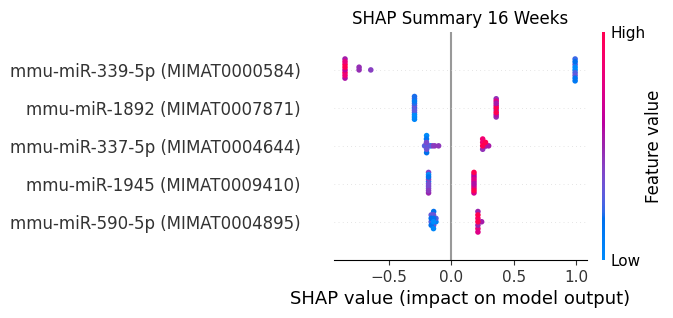

In [22]:
plot_shap_summary(shap_values_all_weeks, X_all_weeks, "SHAP Summary All Weeks")
plot_shap_summary(shap_values_8_weeks, X_8_weeks, "SHAP Summary 8 Weeks")
plot_shap_summary(shap_values_16_weeks, X_16_weeks, "SHAP Summary 16 Weeks")

## SHAP heatmaps

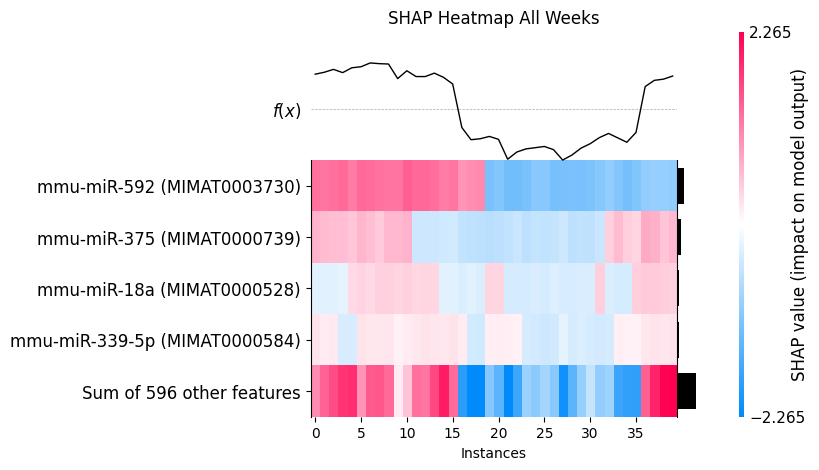

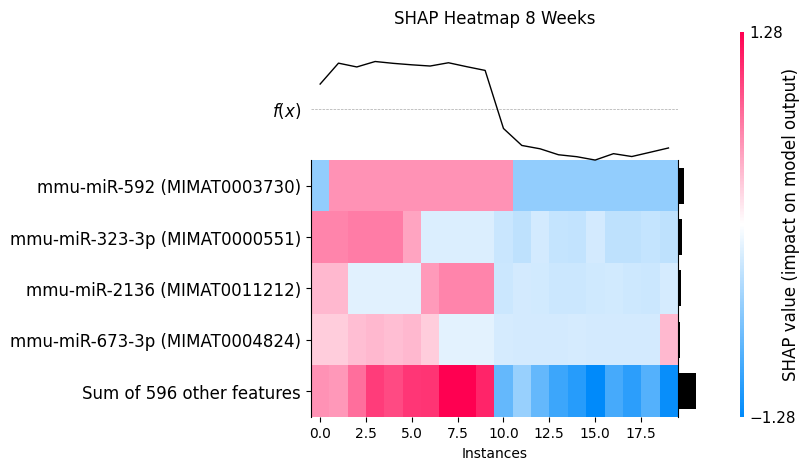

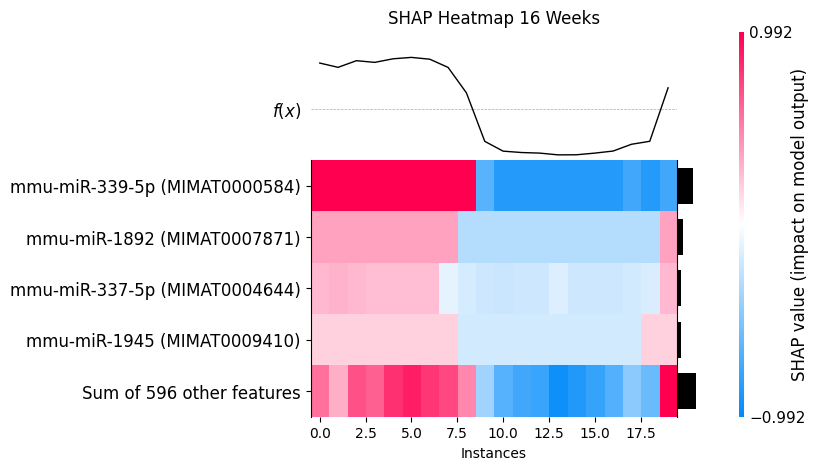

In [23]:
plot_shap_heatmap(shap_values_all_weeks, "SHAP Heatmap All Weeks")
plot_shap_heatmap(shap_values_8_weeks, "SHAP Heatmap 8 Weeks")
plot_shap_heatmap(shap_values_16_weeks, "SHAP Heatmap 16 Weeks")

## SHAP dependence plots

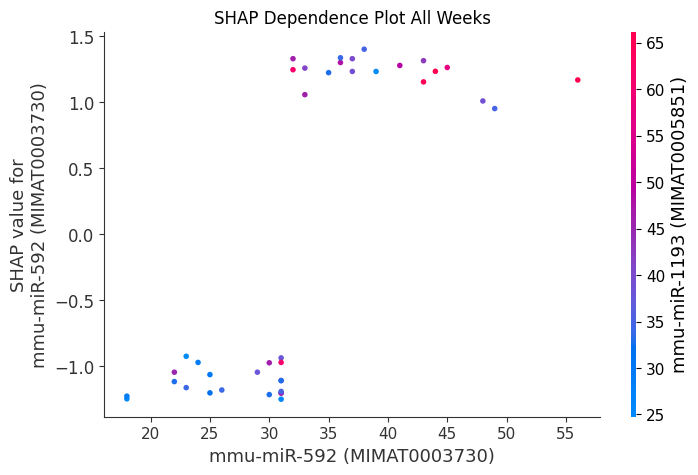

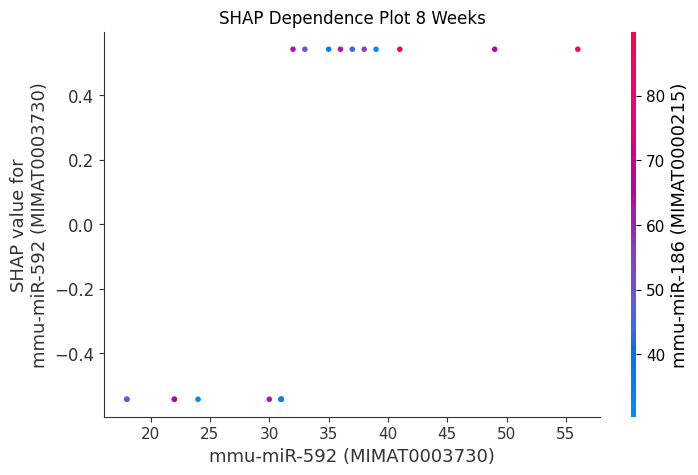

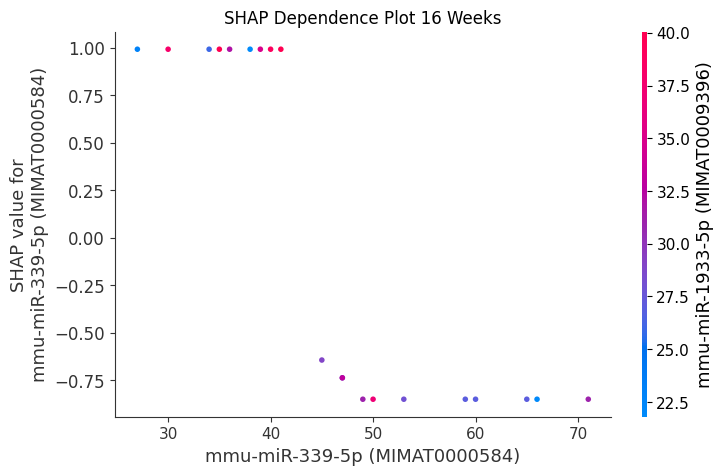

In [24]:
plot_shap_dependence(shap_values_all_weeks, X_all_weeks, "SHAP Dependence Plot All Weeks")
plot_shap_dependence(shap_values_8_weeks, X_8_weeks, "SHAP Dependence Plot 8 Weeks")
plot_shap_dependence(shap_values_16_weeks, X_16_weeks, "SHAP Dependence Plot 16 Weeks")

---

## experiment with grid search for best params

In [25]:
cv_params = {
    'n_estimators': range(1,300),              # default = 100
    'max_depth': range(1, 100),                 # default = 3
    'learning_rate': [.1, .3, .4, .5, .6],     # default = .3
    'colsample_bytree': [.6, .7, .8, .9, 1],   # default = 1,
    'booster':['gbtree']
}

In [26]:
grid_search = GridSearchCV(xgb.XGBRegressor(), cv_params, n_jobs=10, scoring='neg_mean_absolute_error', refit=True)

In [27]:
# # this takes around 1 day to run, so saving the results
# grid_search.fit(X_8_weeks, y_8_weeks)
# grid_search.best_params_

# # results
# {'booster': 'gbtree',
#  'colsample_bytree': 0.7,
#  'learning_rate': 0.1,
#  'max_depth': 2,
#  'n_estimators': 1}

In [28]:
grid_params = {
    'booster': 'gbtree',
    'colsample_bytree': 0.7,
    'learning_rate': 0.1,
    'max_depth': 2,
    'n_estimators': 1
}
model_grid_all = xgb.XGBClassifier(**grid_params).fit(X_all_weeks, y_all_weeks)
model_grid_8 = xgb.XGBClassifier(**grid_params).fit(X_8_weeks, y_8_weeks)
model_grid_16 = xgb.XGBClassifier(**grid_params).fit(X_16_weeks, y_16_weeks)

In [29]:
explainer_grid_all = shap.TreeExplainer(model_grid_all, X_all_weeks, feature_names=X_all_weeks.columns.tolist())
shap_values_grid_all = explainer_grid_all(X_all_weeks)

explainer_grid_8 = shap.TreeExplainer(model_grid_8, X_8_weeks, feature_names=X_8_weeks.columns.tolist())
shap_values_grid_8 = explainer_grid_8(X_8_weeks)

explainer_grid_16 = shap.TreeExplainer(model_grid_16, X_16_weeks, feature_names=X_16_weeks.columns.tolist())
shap_values_grid_16 = explainer_grid_16(X_16_weeks)

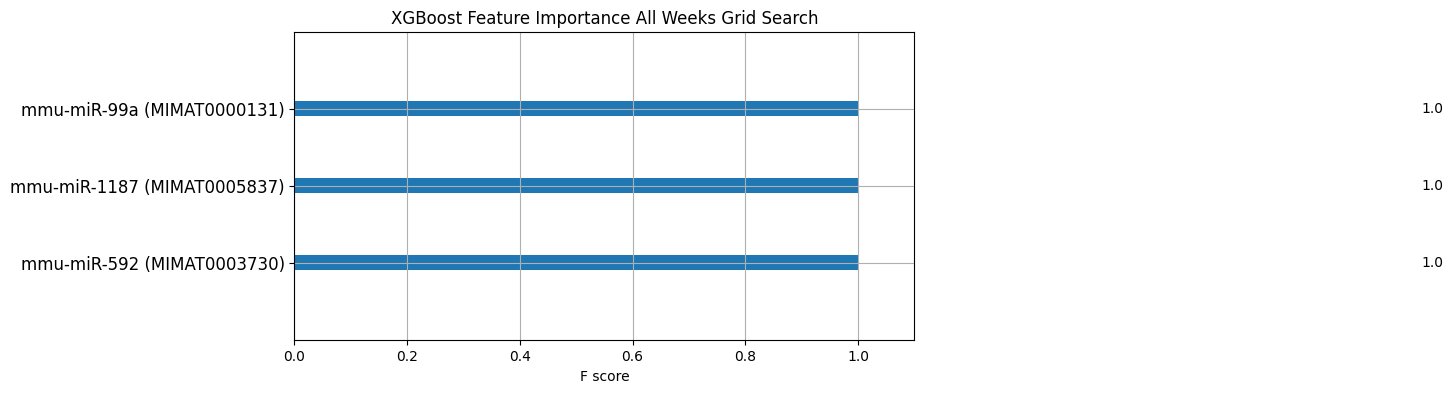

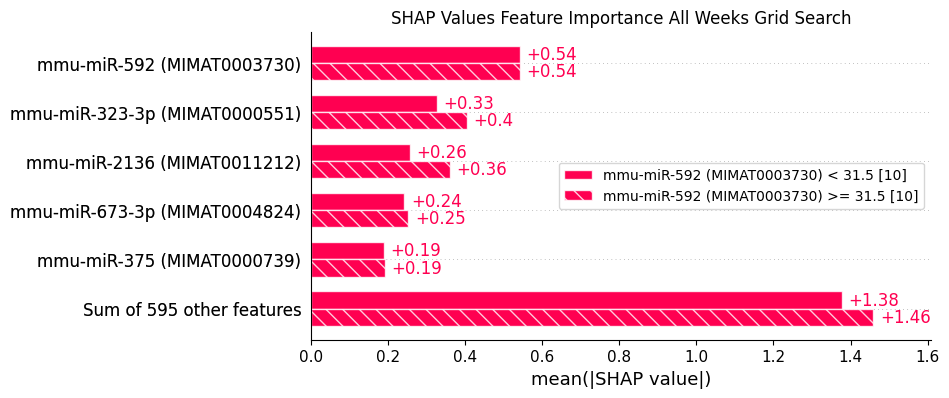

In [30]:
plot_xgb_feature_importance(model_grid_all, 'XGBoost Feature Importance All Weeks Grid Search')
plot_shap_feature_importance(shap_values_8_weeks, 'SHAP Values Feature Importance All Weeks Grid Search')

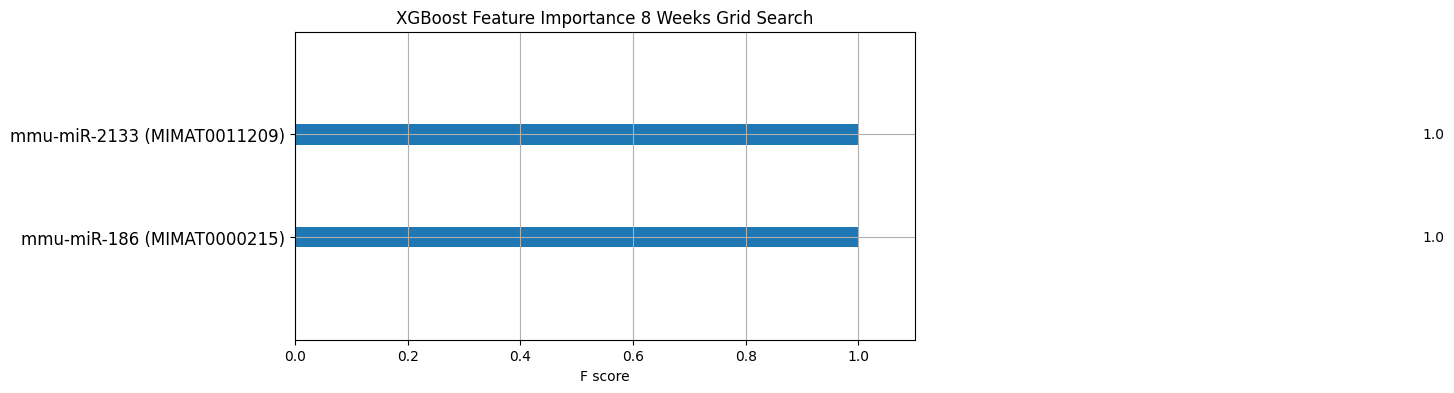

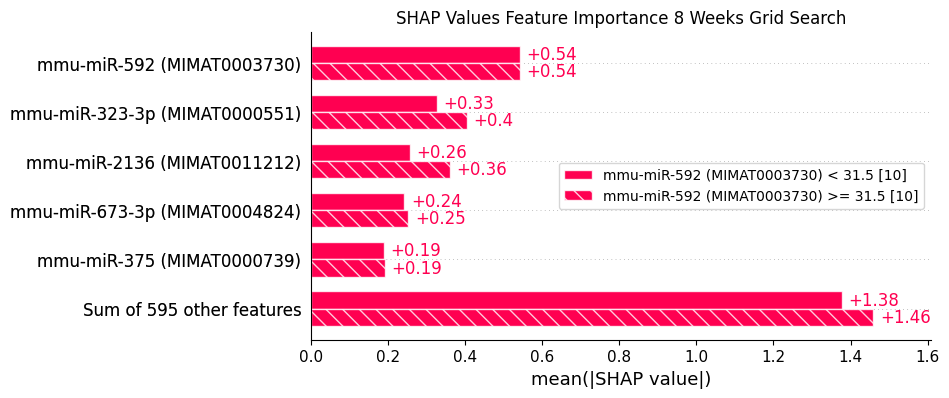

In [31]:
plot_xgb_feature_importance(model_grid_8, 'XGBoost Feature Importance 8 Weeks Grid Search')
plot_shap_feature_importance(shap_values_8_weeks, 'SHAP Values Feature Importance 8 Weeks Grid Search')

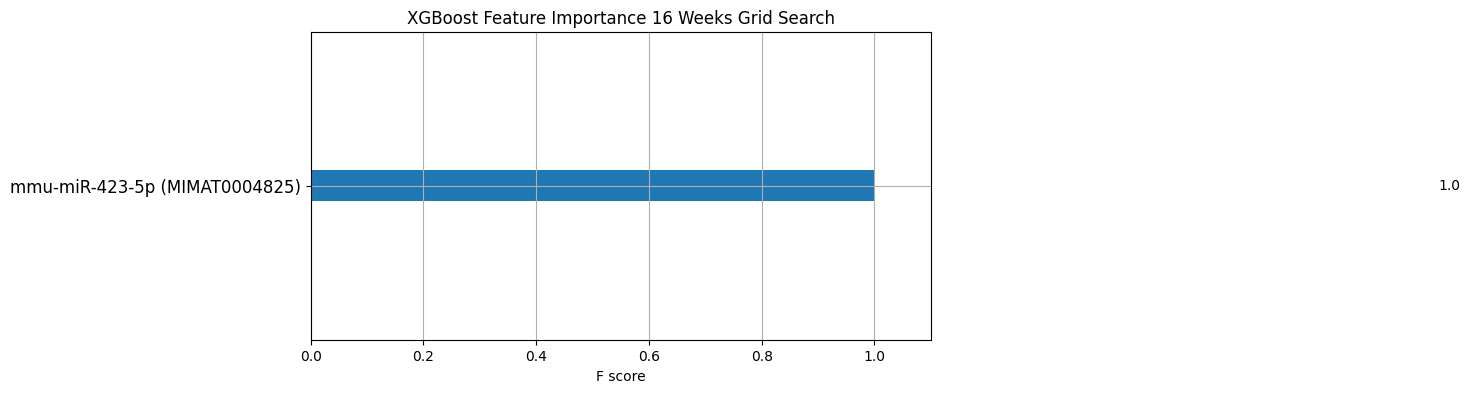

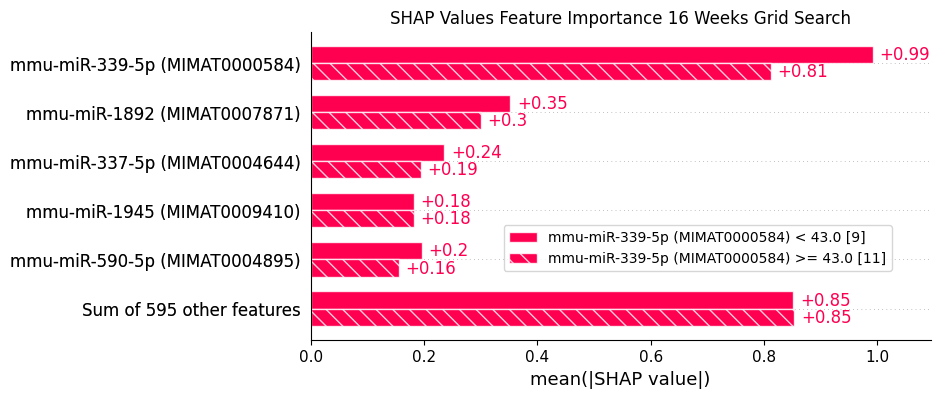

In [32]:
plot_xgb_feature_importance(model_grid_16, 'XGBoost Feature Importance 16 Weeks Grid Search')
plot_shap_feature_importance(
    shap_values_16_weeks, 
    'SHAP Values Feature Importance 16 Weeks Grid Search',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2)
)

----

### expirment with increased extimators and tree depth

In [33]:
increased_params = {
    'booster': 'gbtree',
    'colsample_bytree': 0.7,
    'learning_rate': 0.1,
    'max_depth': 600,
    'n_estimators': 600,
    'random_state': 42
}
model_increased_all = xgb.XGBClassifier(**increased_params).fit(X_all_weeks, y_all_weeks)
model_increased_8 = xgb.XGBClassifier(**increased_params).fit(X_8_weeks, y_8_weeks)
model_increased_16 = xgb.XGBClassifier(**increased_params).fit(X_16_weeks, y_16_weeks)

In [34]:
explainer_increased_all = shap.TreeExplainer(model_increased_all, X_all_weeks, feature_names=X_all_weeks.columns.tolist())
shap_values_increased_all = explainer_increased_all(X_all_weeks)

explainer_increased_8 = shap.TreeExplainer(model_increased_8, X_8_weeks, feature_names=X_8_weeks.columns.tolist())
shap_values_increased_8 = explainer_increased_8(X_8_weeks)

explainer_increased_16 = shap.TreeExplainer(model_increased_16, X_16_weeks, feature_names=X_16_weeks.columns.tolist())
shap_values_increased_16 = explainer_increased_16(X_16_weeks)

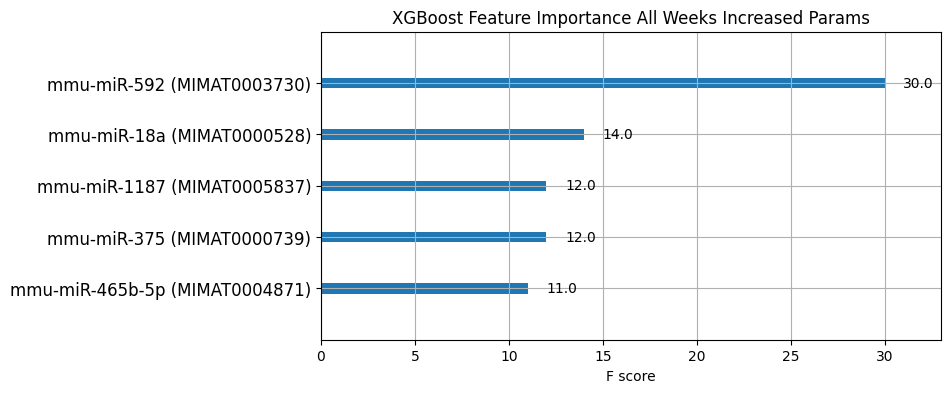

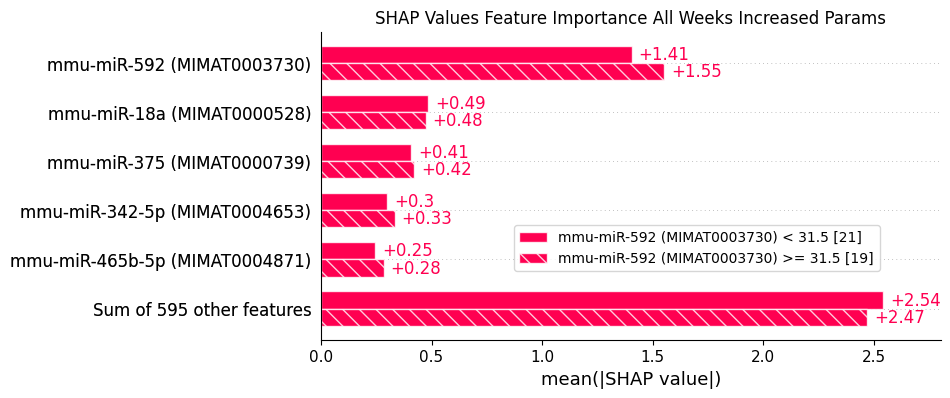

In [35]:
plot_xgb_feature_importance(model_increased_all, 'XGBoost Feature Importance All Weeks Increased Params')
plot_shap_feature_importance(
    shap_values_increased_all, 
    'SHAP Values Feature Importance All Weeks Increased Params',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2)
)

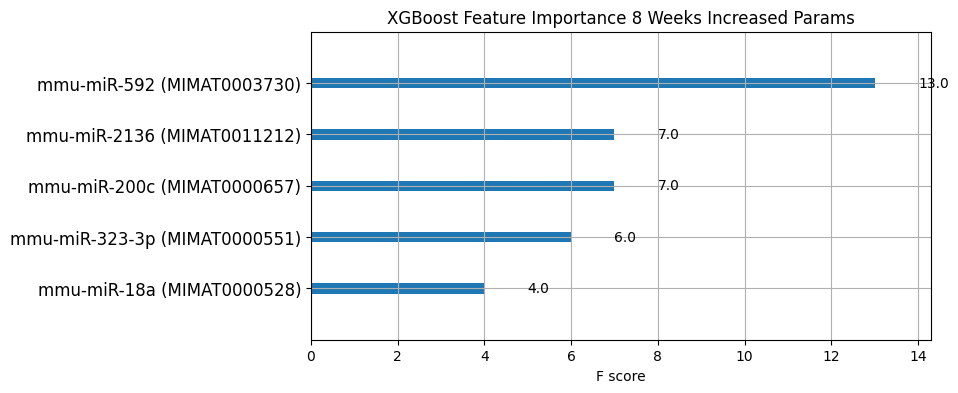

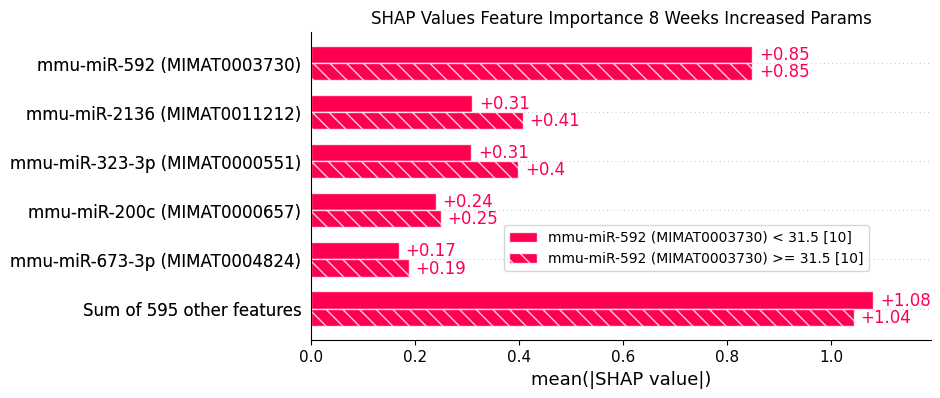

In [36]:
plot_xgb_feature_importance(model_increased_8, 'XGBoost Feature Importance 8 Weeks Increased Params')
plot_shap_feature_importance(
    shap_values_increased_8, 
    'SHAP Values Feature Importance 8 Weeks Increased Params',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2)
)

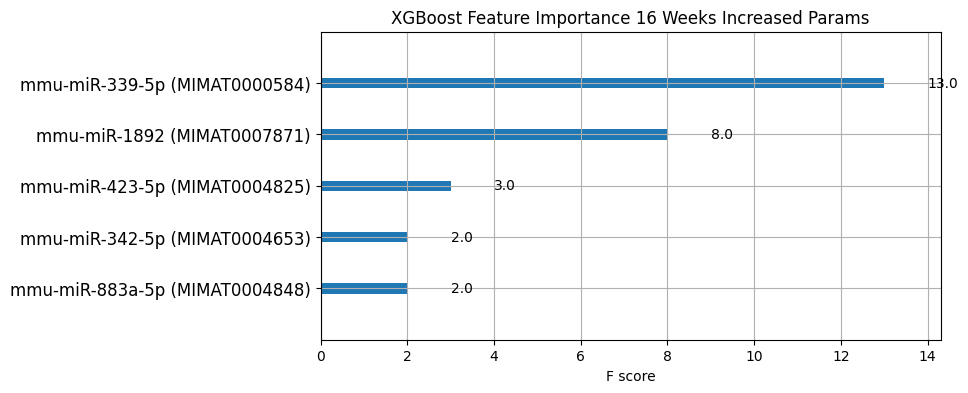

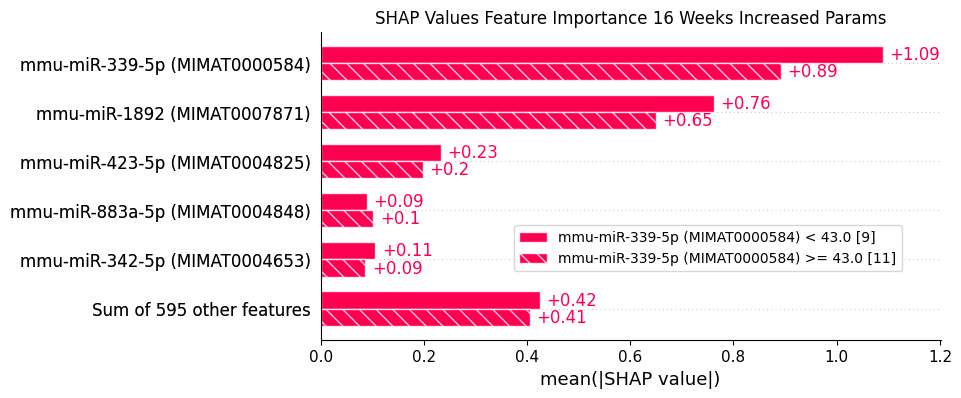

In [37]:
plot_xgb_feature_importance(model_increased_16, 'XGBoost Feature Importance 16 Weeks Increased Params')
plot_shap_feature_importance(
    shap_values_increased_16, 
    'SHAP Values Feature Importance 16 Weeks Increased Params',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2)
)

---

## experiment with VIF

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [39]:
vif_df = pd.DataFrame()
vif_df["feature"] = X_8_weeks.columns
vif_df["VIF"] = [variance_inflation_factor(X_8_weeks.values, i) for i in range(len(X_8_weeks.columns))]

In [40]:
len(X_8_weeks.columns) == X_8_weeks.shape[1]

True

In [41]:
vif_df.head()

,feature,VIF
0,mmu-miR-186 (MIMAT0000215),inf
1,mmu-miR-20a+mmu-miR-20b (MIMAT0000529),inf
2,mmu-miR-713 (MIMAT0003504),inf
3,mmu-miR-694 (MIMAT0003474),inf
4,mmu-miR-582-5p (MIMAT0005291),inf


## expirement with recursive feature elemination

In [42]:
from sklearn.feature_selection import RFECV, RFE

In [43]:
params = {
    "random_state": 42,
    "objective":"binary:logistic",
    "colsample_bytree": 0.3, 
    "learning_rate": 0.1,
    #"nfold": 5,
    #"num_boost_round": 100, 
    #"early_stopping_rounds": 10, 
    #"metrics": "auc"
}   

In [44]:
selector_all = RFECV(xgb.XGBClassifier(**params), cv=5, min_features_to_select=100, scoring='accuracy')
selector_8 = RFECV(xgb.XGBClassifier(**params), cv=5, min_features_to_select=100, scoring='accuracy')
selector_16 = RFECV(xgb.XGBClassifier(**params), cv=5, min_features_to_select=100, scoring='accuracy')

In [45]:
selector_all = selector_all.fit(X_all_weeks, y_all_weeks)
selector_8 = selector_8.fit(X_8_weeks, y_8_weeks)
selector_16 = selector_16.fit(X_8_weeks, y_16_weeks)

In [46]:
selected_all_cols = list(selector_all.feature_names_in_[selector_all.support_])
X_all_selected = X_all_weeks[selected_all_cols]

selected_8_cols = list(selector_8.feature_names_in_[selector_8.support_])
X_8_selected = X_8_weeks[selected_8_cols]

selected_16_cols = list(selector_16.feature_names_in_[selector_16.support_])
X_16_selected = X_16_weeks[selected_16_cols]

In [47]:
model_selected_all = xgb.XGBClassifier(**params).fit(X_all_selected, y_all_weeks)
model_selected_8 = xgb.XGBClassifier(**params).fit(X_8_selected, y_8_weeks)
model_selected_16 = xgb.XGBClassifier(**params).fit(X_16_selected, y_16_weeks)

In [48]:
explainer_selected_all = shap.TreeExplainer(model_selected_all, X_all_selected, feature_names=X_all_selected.columns.tolist())
shap_values_selected_all = explainer_selected_all(X_all_selected)

explainer_selected_8 = shap.TreeExplainer(model_selected_8, X_8_selected, feature_names=X_8_selected.columns.tolist())
shap_values_selected_8 = explainer_selected_8(X_8_selected)

explainer_selected_16 = shap.TreeExplainer(model_selected_16, X_16_selected, feature_names=X_16_selected.columns.tolist())
shap_values_selected_16 = explainer_selected_16(X_16_selected)

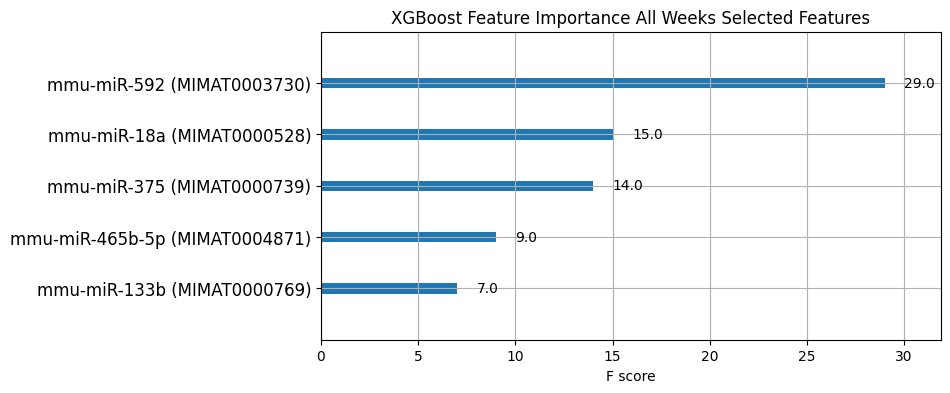

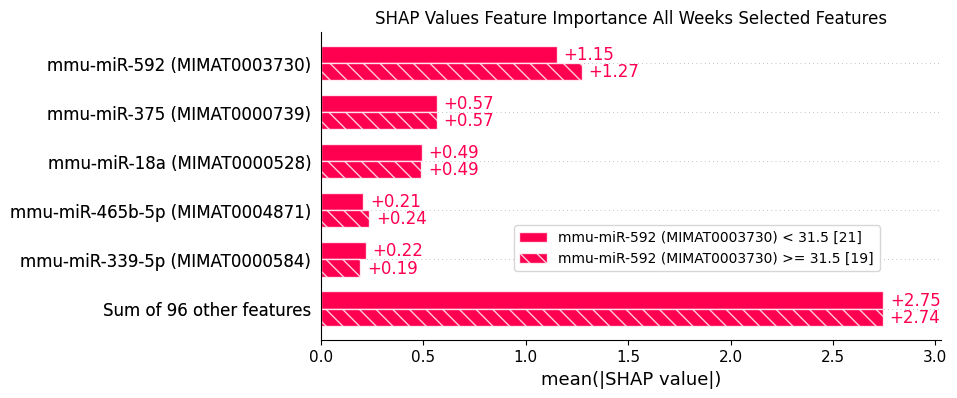

In [49]:
plot_xgb_feature_importance(model_selected_all, 'XGBoost Feature Importance All Weeks Selected Features')
plot_shap_feature_importance(
    shap_values_selected_all, 
    'SHAP Values Feature Importance All Weeks Selected Features',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2)
)

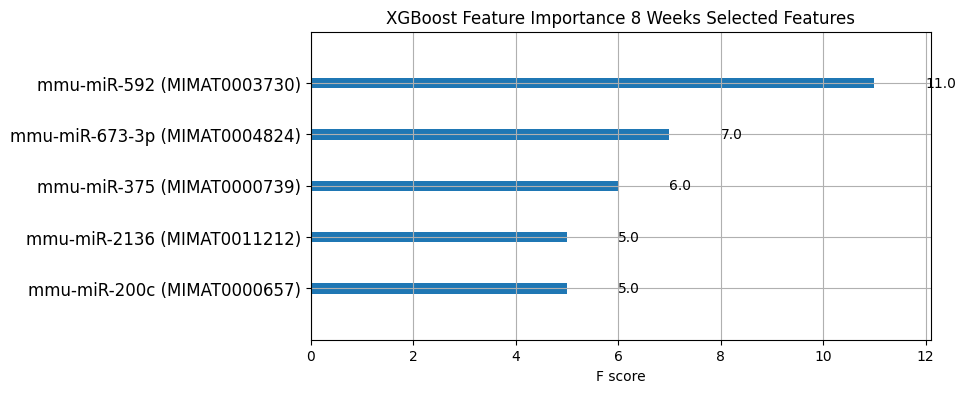

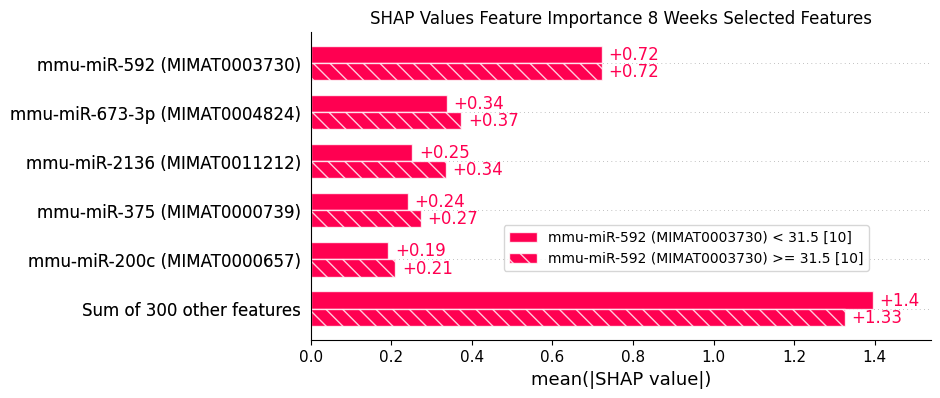

In [50]:
plot_xgb_feature_importance(model_selected_8, 'XGBoost Feature Importance 8 Weeks Selected Features')
plot_shap_feature_importance(
    shap_values_selected_8, 
    'SHAP Values Feature Importance 8 Weeks Selected Features',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2)
)

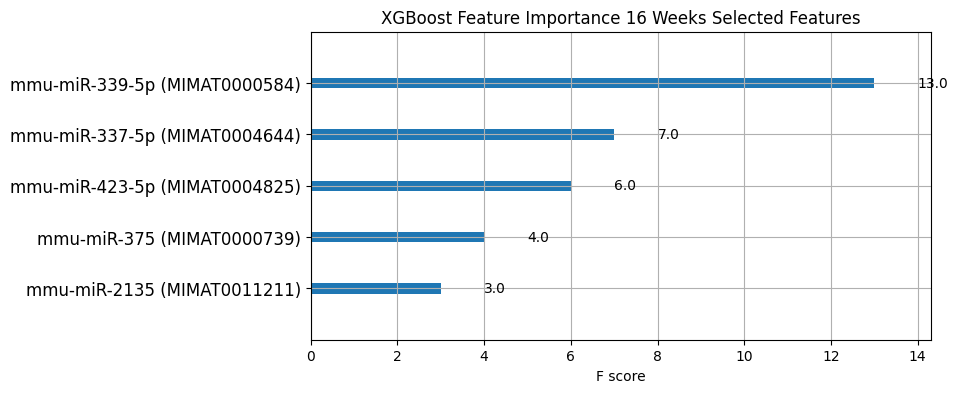

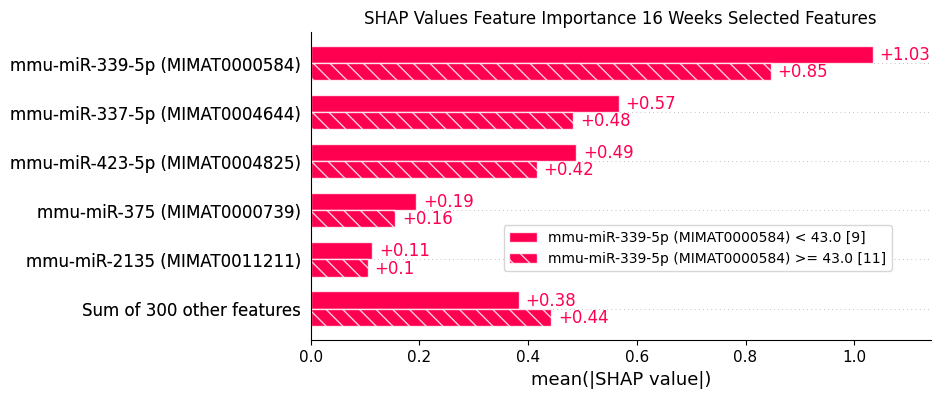

In [51]:
plot_xgb_feature_importance(model_selected_16, 'XGBoost Feature Importance 16 Weeks Selected Features')
plot_shap_feature_importance(
    shap_values_selected_16, 
    'SHAP Values Feature Importance 16 Weeks Selected Features',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2)
)